In [ ]:
# This generates a spectrum of an exozodi 
# (worry about making it resolved later)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.physical_models import BlackBody
from astropy import units as u
from scipy.integrate import quad

In [ ]:
# surface brightness profile is
# Ref.: Eqn. 1 in Kennedy 2015 ApJSS 216:23
#
# S_disk = Sigma_m * BB(lambda, T(r))
#
# where 
# 
# Sigma_m = z * Sigma_m_0 * (r/r0)^(-alpha), where z is number of zodis and Sigma_m_0 normalizes the surface brightness
# T(r) = 278.3K * Ls^(0.25) * r^-(0.5)

In [2]:
def T_temp(Ls, r):
    # Ls: luminosity of star (units L_sol)
    # r: radius in disk (units AU)

    T = 278.3*u.K * (Ls**0.25) * (r**-0.5)

    return T

In [3]:
def Sigma_m(r, r0, alpha, z, Sigma_m_0):
    # r: radius in disk (units AU)
    # r0: reference radius (units AU)
    # alpha: power law index
    # z: number of zodis
    # Sigma_m_0: normalization factor
    #   Kennedy: 'is to be set at some r0 (in AU) such that the surface density is in units of zodis z (see Section 2.2.3).'

    Sigma_m = z * Sigma_m_0 * (r/r0)**(-alpha)

    return Sigma_m

In [4]:
# spectral surface brightness profile I(lambda, r)

# Eqn. 16 in Dannert+ 2022 A&A 664:A22 
# Slight variation in notation: Eqn. 1 in Kennedy+ 2015 ApJSS 216:23
# N.b. Kennedy uses 'S' instead of 'I' 
def I_disk_lambda_r(r, r0, alpha, z, Sigma_m_0, Ls, radius, wavel_array):

    bb = BlackBody(temperature=T_temp(Ls=Ls, r=r),  scale=1.0*u.W/(u.m**2*u.micron*u.sr))

    return Sigma_m(r=r, r0=r0, alpha=alpha, z=z, Sigma_m_0=Sigma_m_0) * bb(wavel_array)

In [7]:
# surface brightness as function of wavelength I(lambda): I_disk_lambda_r integrated over dA = r dr dtheta
def I_disk_lambda(r_array, r0, alpha, z, Sigma_m_0, T_temp, wavel_array):
    
    # Integrate over r * I_disk_lambda_r() dr from r[0] to r[-1]
    I_lambda = []
    for lam in np.array(wavel_array):
        integrand = np.array(
                        [r * Sigma_m(r=r, r0=r0, alpha=alpha, z=z, Sigma_m_0=Sigma_m_0) * BlackBody(temperature=T_temp(Ls=1, r=r),  
                        scale=1.0*u.W/(u.m**2*u.micron*u.sr))(lam) for r in r_array]
                        )
        I_lam, error = 2 * np.pi * quad(integrand, r_array)
        I_lambda.append(I_lam) # conversion term is to convert pc and m 

    return np.array(I_lambda)

In [9]:
bb = BlackBody(temperature=10000*u.K, scale=1.0*u.W/(u.m**2*u.micron*u.sr))

bb(15*u.um)

<Quantity 1558.02364117 W / (micron sr m2)>

In [13]:
# set up some basic params

r_array = np.arange(0.1, 10, 0.1)
r0 = 1
alpha = 0.5
z = 3
Sigma_m_0 = 1
Ls = 1

T_array = T_temp(Ls=Ls, r=r_array)
wavel_array = np.arange(2., 20, 0.1) * u.um

In [15]:
test = I_disk_lambda(r_array=r_array, r0=r0, alpha=alpha, z=z, Sigma_m_0=Sigma_m_0, T_temp=T_array, wavel_array=wavel_array)

TypeError: 'Quantity' object is not callable

In [ ]:
# scale emission for distance from Earth (effectively doing I_disk_lambda, except that integral is over d_Omega = r dr dtheta / D**2)
def I_disk_lambda_Earth(I_disk_lambda_array, D):
    return I_disk_lambda_array * (1 / 206265.)**2

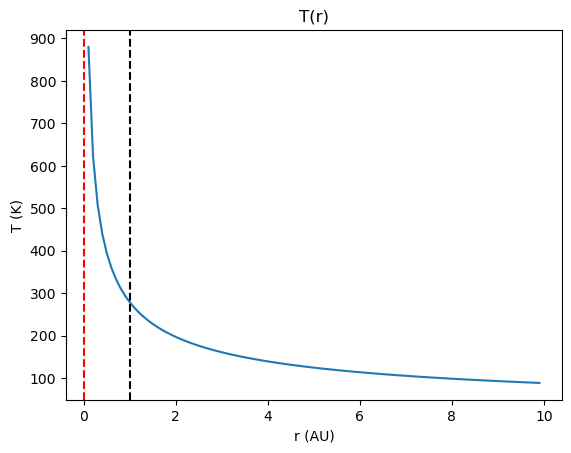

In [ ]:
# temperature profile

Ls = 1


plt.plot(r, T_temp(Ls=Ls, r=r_array))
plt.title(f'T(r)')
plt.xlabel('r (AU)')
plt.ylabel('T (K)')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')
plt.show()

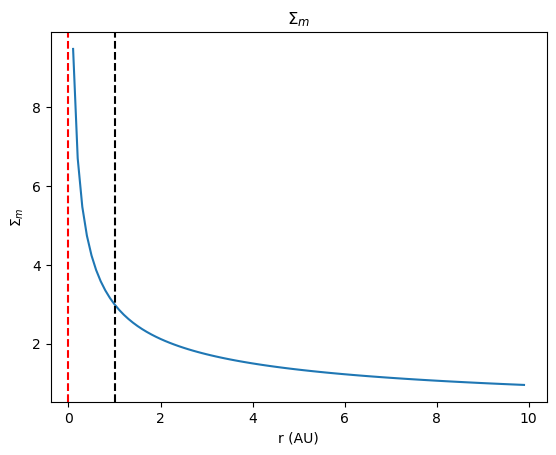

In [ ]:
# Sigma_m profile

plt.plot(r, Sigma_m(r, r0, alpha, z, Sigma_m_0))
plt.title(r'$\Sigma_{m}$')
plt.xlabel('r (AU)')
plt.ylabel(r'$\Sigma_{m}$')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')
plt.show()

In [ ]:
bb_planet_lambda = BlackBody(temperature=temp_bb_planet*u.K,  scale=1.0*u.W/(u.m**2*u.micron*u.sr))